# 7. 데이터 준비하기 : 다듬기, 변형, 병합

In [1]:
from pandas import Series, DataFrame
import pandas as pd
import numpy as np

## 7.2 재형성과 피벗

표 형식의 데이터를 재배치하는 다양한 연산이 존재하는데, 이런 연산을 재형성 또는 피벗 연산이라고 한다.

### 7.2.1 계층적 색인으로 재형성하기

계층적 색인은 다음과 같은 Dataframe의 데이터를 재배치하는 한결같은 방식을 제공한다.
- stack : 데이터의 column을 row로 피벗 또는 회전시킨다.
- unstack : 데이터의 row를 column으로 피벗시킨다.

In [2]:
data = DataFrame(np.arange(6).reshape((2, 3)),
                 index=pd.Index(['Ohio', 'Colorado'], name='state'),
                 columns=pd.Index(['one', 'two', 'three'], name='number'))
data

number,one,two,three
state,,,
Ohio,0,1,2
Colorado,3,4,5


In [3]:
# stack 메서드를 사용하면 Column이 Row로 피벗되어 Series객체를 반환
result = data.stack()

In [4]:
# 다시 unstack 메서드를 사용하면 계층적 색인을 가진 Series로부터 DataFrame을 얻는다.
# 보통 가장 안쪽에 있는 Index나 Column부터 끄집어 낸다.
result.unstack()

number,one,two,three
state,,,
Ohio,0,1,2
Colorado,3,4,5


In [5]:
# 끄집어 낼 대상을 지정할수도 있다.
result.unstack(0)

state,Ohio,Colorado
number,,
one,0,3
two,1,4
three,2,5


In [6]:
result.unstack('state')

state,Ohio,Colorado
number,,
one,0,3
two,1,4
three,2,5


In [7]:
s1 = Series([0, 1, 2, 3], index=['a', 'b', 'c', 'd'])
s1

a    0
b    1
c    2
d    3
dtype: int64

In [8]:
s2 = Series([4, 5, 6], index=['c', 'd', 'e'])
s2

c    4
d    5
e    6
dtype: int64

In [9]:
# 해당 레벨에 있는 모든 값이 하위 그룹에 속하지 않을 경우 
# unstack을 하면 누락된 데이터가 생길 수 있다.
data2 = pd.concat([s1, s2], keys=['one', 'two'])
data2

one  a    0
     b    1
     c    2
     d    3
two  c    4
     d    5
     e    6
dtype: int64

In [10]:
data2.unstack()

,a,b,c,d,e
one,0.0,1.0,2.0,3.0,NaN
two,NaN,NaN,4.0,5.0,6.0


In [11]:
# 반면 stack 메서드는 누락된 데이터를 자동으로 걸러낸다.
data2.unstack().stack()

one  a    0.0
     b    1.0
     c    2.0
     d    3.0
two  c    4.0
     d    5.0
     e    6.0
dtype: float64

In [12]:
# 누락된 데이터를 걸러내고 싶지 않으면 dropna 옵션을 주면 된다.
data2.unstack().stack(dropna=False)

one  a    0.0
     b    1.0
     c    2.0
     d    3.0
     e    NaN
two  a    NaN
     b    NaN
     c    4.0
     d    5.0
     e    6.0
dtype: float64

In [13]:
# DataFrame을 unstack할 때, unstack 레벨은 결과에서 가장 낮은 단계가 된다.
df = DataFrame({'left': result, 'right': result + 5},
              columns=pd.Index(['left', 'right'], name='side'))
df

side             left  right
state    number             
Ohio     one        0      5
         two        1      6
         three      2      7
Colorado one        3      8
         two        4      9
         three      5     10

In [14]:
df.unstack('state')

side   left          right         
state  Ohio Colorado  Ohio Colorado
number                             
one       0        3     5        8
two       1        4     6        9
three     2        5     7       10

In [15]:
df.unstack('state').stack('side')

state         Ohio  Colorado
number side                 
one    left      0         3
       right     5         8
two    left      1         4
       right     6         9
three  left      2         5
       right     7        10

### 7.2.2 피버팅으로 데이터 나열 방식 바꾸기

데이터베이스나 CSV 파일에 여러 개의 시계열 데이터를 저장하는 일반적인 방법은 시간순으로 나열하는 방법이다.

In [16]:
data = pd.read_csv('macrodata.csv')
periods = pd.PeriodIndex(year=data.year, quarter=data.quarter, name='date')
data = DataFrame(data.to_records(),
                columns=pd.Index(['realgdp', 'infl', 'unemp'], name='item'),
                index=periods.to_timestamp('D', 'end'))
ldata = data.stack().reset_index().rename(columns={0:'value'})
ldata[:10]

,date,item,value
0,1959-03-31,realgdp,2710.349
1,1959-03-31,infl,0.000
2,1959-03-31,unemp,5.800
3,1959-06-30,realgdp,2778.801
4,1959-06-30,infl,2.340
5,1959-06-30,unemp,5.100
6,1959-09-30,realgdp,2775.488
7,1959-09-30,infl,2.740
8,1959-09-30,unemp,5.300
9,1959-12-31,realgdp,2785.204


In [17]:
# 하나의 DataFrame에 date 컬럼의 시간 값으로 색인된 개별 item을
# 컬럼으로 포함시키는 것을 선호하는 경향이 있다.
# pivot 매서드가 이러한 변형을 지원한다. ex) pivot(row, column, value)
pivoted = ldata.pivot('date', 'item', 'value')
pivoted.head()

item,infl,realgdp,unemp
date,,,
1959-03-31,0.00,2710.349,5.8
1959-06-30,2.34,2778.801,5.1
1959-09-30,2.74,2775.488,5.3
1959-12-31,0.27,2785.204,5.6
1960-03-31,2.31,2847.699,5.2


In [18]:
# 한 번에 2개의 컬럼을 변형해보자
ldata['value2'] = np.random.randn(len(ldata))
ldata.head()

,date,item,value,value2
0,1959-03-31,realgdp,2710.349,-0.005037
1,1959-03-31,infl,0.000,1.233990
2,1959-03-31,unemp,5.800,0.588685
3,1959-06-30,realgdp,2778.801,-1.132452
4,1959-06-30,infl,2.340,1.159901


In [19]:
# 마지막 인자(value)를 생략하면 계층적 컬럼을 얻을 수 있다.
pivoted = ldata.pivot('date', 'item')
pivoted.head()

value                    value2                    
item        infl   realgdp unemp      infl   realgdp     unemp
date                                                          
1959-03-31  0.00  2710.349   5.8  1.233990 -0.005037  0.588685
1959-06-30  2.34  2778.801   5.1  1.159901 -1.132452 -0.992109
1959-09-30  2.74  2775.488   5.3 -0.691854  0.002856  2.549564
1959-12-31  0.27  2785.204   5.6  1.215571  1.033656 -0.395048
1960-03-31  2.31  2847.699   5.2 -1.555200 -0.596361  0.427582

In [20]:
# set_index를 사용해서 계층적 색인을 만들고,
# unstack 메소드를 사용하는것과 같은 효과이다.
unstacked = ldata.set_index(['date', 'item']).unstack('item')
unstacked.head()

value                    value2                    
item        infl   realgdp unemp      infl   realgdp     unemp
date                                                          
1959-03-31  0.00  2710.349   5.8  1.233990 -0.005037  0.588685
1959-06-30  2.34  2778.801   5.1  1.159901 -1.132452 -0.992109
1959-09-30  2.74  2775.488   5.3 -0.691854  0.002856  2.549564
1959-12-31  0.27  2785.204   5.6  1.215571  1.033656 -0.395048
1960-03-31  2.31  2847.699   5.2 -1.555200 -0.596361  0.427582

## 7.3 데이터 변형

지금까지 데이터를 재배치하는 방법을 알아보았다.
이제 필터링, 정제 및 다른 변형을 하는 법을 알아보려고 한다.

### 7.3.1 중복 제거하기

In [21]:
# 여러가지 이유로 Dataframe에서 중복된 로우를 발견할 수 있다.
data = DataFrame({'k1': ['one'] * 3 + ['two'] * 4,
                  'k2': [1, 1, 2, 3, 3, 4, 4]})
data

,k1,k2
0,one,1
1,one,1
2,one,2
3,two,3
4,two,3
5,two,4
6,two,4


In [22]:
# duplicated 메소드는 각 로우가 중복인지를 알려주는 Series 객체를 반환한다.
data.duplicated()

0    False
1     True
2    False
3    False
4     True
5    False
6     True
dtype: bool

In [23]:
# duplicated 메소드의 False값만 반환할 수 있다.
data.drop_duplicates()

,k1,k2
0,one,1
2,one,2
3,two,3
5,two,4


In [24]:
# 중복은 모든 컬럼을 대상으로 비교한다.
# 특정 컬럼에 대해서만 중복비교, 제거를 할 수 있다.
data['v1'] = range(7)
data

,k1,k2,v1
0,one,1,0
1,one,1,1
2,one,2,2
3,two,3,3
4,two,3,4
5,two,4,5
6,two,4,6


In [25]:
data.drop_duplicates(['k1'])

,k1,k2,v1
0,one,1,0
3,two,3,3


In [26]:
# 마지막으로 발견된 값을 반환하도록 할 수 있다.
# keep옵션은 'first', 'last'옵션이 있으며, default값이 'first'이다.
data.drop_duplicates(['k1', 'k2'], keep='last')

,k1,k2,v1
1,one,1,1
2,one,2,2
4,two,3,4
6,two,4,6


### 7.3.2 함수나 매핑 이용해 데이터 변형하기

In [27]:
# DataFrame의 컬럼이나 Series, 배열 안의 값을 기반으로 데이터의 형태를 변형할 수 있다.
data = DataFrame({'food': ['bacon', 'pulled pork', 'bacon', 'Pastrami',
                           'corned beef', 'Bacon', 'pastrami',
                           'honey ham', 'nova lox'],
                  'ounces': [4, 3, 12, 6, 7.5, 8, 3, 5, 6]})
data

,food,ounces
0,bacon,4.0
1,pulled pork,3.0
2,bacon,12.0
3,Pastrami,6.0
4,corned beef,7.5
5,Bacon,8.0
6,pastrami,3.0
7,honey ham,5.0
8,nova lox,6.0


In [28]:
# 해당 육류가 어떤 동물의 고기인지 알려줄 수 있는 컬럼을 추가한다고 가정하자.
meat_to_animal = {
                  'bacon': 'pig',
                  'pulled pork': 'pig',
                  'pastrami': 'cow',
                  'corned beef': 'cow',
                  'honey ham': 'pig',
                  'nova lox': 'salmon'
                  }
meat_to_animal

{'bacon': 'pig',
 'corned beef': 'cow',
 'honey ham': 'pig',
 'nova lox': 'salmon',
 'pastrami': 'cow',
 'pulled pork': 'pig'}

In [29]:
# Series의 map 메소드는 사전류의 객체나 함수를 받을 수 있는데, 
# 이 데이터에는 육류의 이름에 대소문자가 섞여있는 문제가 있으므로 모두 소문자로 변경한다.
data['animal'] = data['food'].map(str.lower).map(meat_to_animal)
data

,food,ounces,animal
0,bacon,4.0,pig
1,pulled pork,3.0,pig
2,bacon,12.0,pig
3,Pastrami,6.0,cow
4,corned beef,7.5,cow
5,Bacon,8.0,pig
6,pastrami,3.0,cow
7,honey ham,5.0,pig
8,nova lox,6.0,salmon


In [30]:
# 함수를 넘겨서 같은 일을 수행 할 수도 있다.
data['food'].map(lambda x: meat_to_animal[x.lower()])

0       pig
1       pig
2       pig
3       cow
4       cow
5       pig
6       cow
7       pig
8    salmon
Name: food, dtype: object

### 7.3.3 값 치환하기

In [31]:
# 누락된 값을 채우는 일은 일반적으로 fillna를 이용한다.
# replace 메소드를 사용하면 조금 더 간단하고 유연하게 값을 치환할 수 있다.
data = Series([1., -999., 2., -999., -1000., 3.])
data

0       1.0
1    -999.0
2       2.0
3    -999.0
4   -1000.0
5       3.0
dtype: float64

In [32]:
# -999값을 모두 NaN으로 변경해보자
data.replace(-999, np.nan)

0       1.0
1       NaN
2       2.0
3       NaN
4   -1000.0
5       3.0
dtype: float64

In [33]:
# 여러 개의 값을 한 번에 치환할 수 있다.
data.replace([-999, -1000], np.nan)

0    1.0
1    NaN
2    2.0
3    NaN
4    NaN
5    3.0
dtype: float64

In [34]:
# 치환하려는 값을 다르게 지정하려면 값도 리스트를 넣어주면 된다.
data.replace([-999, -1000], [np.nan, 0])

0    1.0
1    NaN
2    2.0
3    NaN
4    0.0
5    3.0
dtype: float64

In [35]:
# 사전을 이용해 치환하려는 값마다 다른 값을 넣을 수 있다.
data.replace({-999: np.nan, -1000: 0})

0    1.0
1    NaN
2    2.0
3    NaN
4    0.0
5    3.0
dtype: float64

### 7.3.4 축 색인 이름 바꾸기

In [36]:
# Series의 값처럼 축 이름 역시 유사한 방식으로 함수나 새롭게 바꿀 값으로 변형할 수 있다.
data = DataFrame(np.arange(12).reshape((3, 4)),
                 index = ['Ohio', 'Colorado', 'New York'],
                 columns=['one', 'two', 'three', 'four'])
data

,one,two,three,four
Ohio,0,1,2,3
Colorado,4,5,6,7
New York,8,9,10,11


In [37]:
# Series와 마찬가지로 축 색인에도 map 메소드가 있다.
data.index

Index(['Ohio', 'Colorado', 'New York'], dtype='object')

In [38]:
data.index.map(str.upper)

array(['OHIO', 'COLORADO', 'NEW YORK'], dtype=object)

In [39]:
# 대문자로 변경된 축 이름을 DataFrame의 Index에 바로 대입할 수 있다.
data.index = data.index.map(str.upper)
data

,one,two,three,four
OHIO,0,1,2,3
COLORADO,4,5,6,7
NEW YORK,8,9,10,11


In [40]:
# 원래 객체를 변경하지 않고 새로운 객체를 생성하려면 rename메소드를 사용한다.
data.rename(index=str.title, columns=str.upper)

,ONE,TWO,THREE,FOUR
Ohio,0,1,2,3
Colorado,4,5,6,7
New York,8,9,10,11


In [41]:
# rename메소드는 사전 형식의 객체를 이용해서 축 이름 중 일부만 변경하는 것도 가능하다.
data.rename(index={'OHIO': 'INDIANA'},
           columns={'three': 'peekaboo'})

,one,two,peekaboo,four
INDIANA,0,1,2,3
COLORADO,4,5,6,7
NEW YORK,8,9,10,11


In [42]:
# DataFrame을 복사해서 index와 columns 속성을 갱신할 필요 없이 바로 변경할 수 있다.
data.rename(index={'OHIO': 'INDIANA'}, inplace=True)
data

,one,two,three,four
INDIANA,0,1,2,3
COLORADO,4,5,6,7
NEW YORK,8,9,10,11


### 7.3.5 개별화와 양자화

연속성 데이터는 종종 개별로 분할하거나 분석을 위해 그룹별로 나눈다.

In [43]:
# 다음은 수업에 참여하는 학생 그룹 데이터가 있고, 나이대에 따라 구분한다고 가정하자
ages = [20, 22, 25, 27, 21, 23, 27, 31, 61, 45, 41, 32]

In [44]:
# 위 데이터를 pandas의 cut함수를 사용해서 그룹으로 나누어보자
# 18~25, 26~35, 36~60, 61~100
bins = [18, 25, 35, 60, 100]
cats = pd.cut(ages, bins)
cats

[(18, 25], (18, 25], (18, 25], (25, 35], (18, 25], ..., (25, 35], (60, 100], (35, 60], (35, 60], (25, 35]]
Length: 12
Categories (4, object): [(18, 25] < (25, 35] < (35, 60] < (60, 100]]

In [45]:
# cut 메소드는 Categorical 객체를 반환한다.
type(cats)

pandas.core.categorical.Categorical

In [46]:
# 카테고리 이름은 categories에 담겨있다.
cats.categories

Index(['(18, 25]', '(25, 35]', '(35, 60]', '(60, 100]'], dtype='object')

In [47]:
# 원본 리스트가 어떤 카테고리의 인덱스에 포함하는지는 codes를 보면 알 수 있다.
cats.codes

array([0, 0, 0, 1, 0, 0, 1, 1, 3, 2, 2, 1], dtype=int8)

In [48]:
# 카테고리별로 몇개의 데이터가 속하는지는 value_counts메소드를 통해 알 수 있다.
pd.value_counts(cats)

(18, 25]     5
(25, 35]     4
(35, 60]     2
(60, 100]    1
dtype: int64

In [49]:
# 간격을 나타내는 표기법은 괄호로 시작해서 대괄호로 끝나는데
# 괄호는 포함하지 않고, 대괄호는 포함하는 것을 나타낸다.
# 대괄호의 위치를 바꿀수도 있다.
pd.cut(ages, bins, right=False)

[[18, 25), [18, 25), [25, 35), [25, 35), [18, 25), ..., [25, 35), [60, 100), [35, 60), [35, 60), [25, 35)]
Length: 12
Categories (4, object): [[18, 25) < [25, 35) < [35, 60) < [60, 100)]

In [54]:
# 카테고리 이름을 지정해줄 수 있다.
group_names = ['Youth', 'YoungAdult', 'MiddleAged', 'Senior']
pd.cut(ages, bins, labels=group_names)

[Youth, Youth, Youth, YoungAdult, Youth, ..., YoungAdult, Senior, MiddleAged, MiddleAged, YoungAdult]
Length: 12
Categories (4, object): [Youth < YoungAdult < MiddleAged < Senior]

In [55]:
# cut메소드에 명시적으로 그룹의 경계 값을 넘기지 않고, 그룹의 개수를 넘겨주면
# 데이터에서 최소값과 최대값을 기준으로 균등한 길이의 그룹을 자동으로 계산한다.
data = np.random.rand(20)
data

array([ 0.46626141,  0.93774682,  0.43167858,  0.78734594,  0.13472748,
        0.80187895,  0.34256713,  0.27173204,  0.17563817,  0.30522774,
        0.00541097,  0.33620586,  0.669761  ,  0.26984581,  0.3146243 ,
        0.18791533,  0.27564797,  0.19571014,  0.11785744,  0.2368391 ])

In [57]:
temp = pd.cut(data, 4, precision=2)

(0.24, 0.47]      9
(0.0045, 0.24]    7
(0.7, 0.94]       3
(0.47, 0.7]       1
dtype: int64

In [59]:
# 같은 기능의 함수로 qcut이 있는데, 이는 표본 변위치를 기반으로 데이터를 나눈다.
# 표본 변위치 : 표본 전체의 도수를 4등분한 것
data = np.random.randn(1000)
cats = pd.qcut(data, 4)
cats

[[-2.604, -0.679], [-2.604, -0.679], (-0.679, 0.00248], (-0.679, 0.00248], [-2.604, -0.679], ..., (-0.679, 0.00248], (0.00248, 0.674], (0.674, 3.391], (0.674, 3.391], (0.674, 3.391]]
Length: 1000
Categories (4, object): [[-2.604, -0.679] < (-0.679, 0.00248] < (0.00248, 0.674] < (0.674, 3.391]]

In [60]:
# 1000개의 표본이 250개씩 4등분 됨을 볼 수 있다.
pd.value_counts(cats)

(0.674, 3.391]       250
(0.00248, 0.674]     250
(-0.679, 0.00248]    250
[-2.604, -0.679]     250
dtype: int64

In [81]:
#변위치를 직접 지정해줄 수 있다.
data = np.arange(100)
pd.qcut(data, [0, 0.1, 0.5, 0.9, 1.])

[[0, 9.9], [0, 9.9], [0, 9.9], [0, 9.9], [0, 9.9], ..., (89.1, 99], (89.1, 99], (89.1, 99], (89.1, 99], (89.1, 99]]
Length: 100
Categories (4, object): [[0, 9.9] < (9.9, 49.5] < (49.5, 89.1] < (89.1, 99]]

### 7.3.6 특이값 찾아내고 제외하기

In [82]:
# 배열연산을 수행할 때는 특이값을 제외하거나 적당한 값으로 대체하는 것이 중요하다.
np.random.seed(12345)
data = DataFrame(np.random.randn(1000, 4))
data.head()

,0,1,2,3
0,-0.204708,0.478943,-0.519439,-0.555730
1,1.965781,1.393406,0.092908,0.281746
2,0.769023,1.246435,1.007189,-1.296221
3,0.274992,0.228913,1.352917,0.886429
4,-2.001637,-0.371843,1.669025,-0.438570


In [83]:
data.describe()

,0,1,2,3
count,1000.000000,1000.000000,1000.000000,1000.000000
mean,-0.067684,0.067924,0.025598,-0.002298
std,0.998035,0.992106,1.006835,0.996794
min,-3.428254,-3.548824,-3.184377,-3.745356
25%,-0.774890,-0.591841,-0.641675,-0.644144
50%,-0.116401,0.101143,0.002073,-0.013611
75%,0.616366,0.780282,0.680391,0.654328
max,3.366626,2.653656,3.260383,3.927528


In [84]:
# 이 Dataframe의 한 컬럼에서 절대값이 3을 초과하는 값을 찾아내자
col = data[3]
col.head()

0   -0.555730
1    0.281746
2   -1.296221
3    0.886429
4   -0.438570
Name: 3, dtype: float64

In [85]:
col[np.abs(col) > 3]

97     3.927528
305   -3.399312
400   -3.745356
Name: 3, dtype: float64

In [87]:
# 절대값 3을 초과하는 값이 들어있는 모든 로우를 선택할 수 있다.
# axis : 계산하는 방법, 0: Column, 1: Row
data[(np.abs(data) > 3).any(axis=1)]

,0,1,2,3
5,-0.539741,0.476985,3.248944,-1.021228
97,-0.774363,0.552936,0.106061,3.927528
102,-0.655054,-0.565230,3.176873,0.959533
305,-2.315555,0.457246,-0.025907,-3.399312
324,0.050188,1.951312,3.260383,0.963301
400,0.146326,0.508391,-0.196713,-3.745356
499,-0.293333,-0.242459,-3.056990,1.918403
523,-3.428254,-0.296336,-0.439938,-0.867165
586,0.275144,1.179227,-3.184377,1.369891
808,-0.362528,-3.548824,1.553205,-2.186301


In [88]:
(np.abs(data) > 3).any(axis=0)

0    True
1    True
2    True
3    True
dtype: bool

In [89]:
(np.abs(data) > 3).any(axis=1)[:10]

0    False
1    False
2    False
3    False
4    False
5     True
6    False
7    False
8    False
9    False
dtype: bool

In [94]:
# 절대값 3을 초과하는 값을 -3이나 3으로 지정할 수 있다.
data[np.abs(data) > 3] = np.sign(data) * 3
data.describe()

,0,1,2,3
count,1000.000000,1000.000000,1000.000000,1000.000000
mean,-0.067623,0.068473,0.025153,-0.002081
std,0.995485,0.990253,1.003977,0.989736
min,-3.000000,-3.000000,-3.000000,-3.000000
25%,-0.774890,-0.591841,-0.641675,-0.644144
50%,-0.116401,0.101143,0.002073,-0.013611
75%,0.616366,0.780282,0.680391,0.654328
max,3.000000,2.653656,3.000000,3.000000


### 7.3.7 치환과 임의 샘플링

Series나 DataFrame의 Row를 쉽게 임의의 순서대로 재배치할 수 있다.

In [95]:
# 순서를 바꾸고 싶은 만큼의 길이를 permutation 함수에 넘기면
# 바뀐 순서가 담긴 정수배열이 생성된다.
df = DataFrame(np.arange(5 * 4).reshape(5, 4))
df

,0,1,2,3
0,0,1,2,3
1,4,5,6,7
2,8,9,10,11
3,12,13,14,15
4,16,17,18,19


In [96]:
sampler = np.random.permutation(5)
sampler

array([1, 0, 2, 3, 4])

In [97]:
# 이 배열은 인덱스 기반의 색인이나 take함수에서 사용할 수 있다.
df.take(sampler)

,0,1,2,3
1,4,5,6,7
0,0,1,2,3
2,8,9,10,11
3,12,13,14,15
4,16,17,18,19


In [101]:
# 치환 없이 일부만 표본으로 선택하려면 permutation 함수에서 반환된
# 배열에서 원하는 크기 k만큼만 처음부터 잘라내면 된다.
df.take(np.random.permutation(len(df))[:3])

,0,1,2,3
1,4,5,6,7
4,16,17,18,19
0,0,1,2,3


In [102]:
# 치환을 통해 표본을 생성하기 위한 가장 빠른 방법은 randint를 사용한 난수를 이용하는 방법이다.
bag = np.array([5, 7, -1, 6, 4])
bag

array([ 5,  7, -1,  6,  4])

In [104]:
sampler = np.random.randint(0, len(bag), size=10)
sampler

array([1, 2, 0, 4, 4, 4, 3, 4, 2, 2])

In [107]:
draws = bag.take(sampler)
draws

array([ 7, -1,  5,  4,  4,  4,  6,  4, -1, -1])

### 7.3.8 표시자/더미 변수

통계 모델이나 기게학습 애플리케이션을 위한 또 다른 데이터 변형은 분류 값을 더미나 표시행렬로 변환하는 것이다. 만약 어떤 DataFrame의 한 컬럼에 k가지의 값이 있다면 k개의 컬럼이 있는 DataFrame이나 행렬을 만들고 값으로는 1과 0을 채워넣을 것이다. 이 때 사용하는 함수가 pandas의 get_dummies함수인데, 스스로 새로운 방법을 고안해내는것도 어렵지 않다.

In [108]:
df = DataFrame({'key': ['b', 'b', 'a', 'c', 'a', 'b'],
                'data1': range(6)})
df

,data1,key
0,0,b
1,1,b
2,2,a
3,3,c
4,4,a
5,5,b


In [109]:
# 'key'컬럼에는 a, b, c값이 있다.
# 컬럼의 모든 값을 컬럼으로 하고, key값에 해당하는 컬럼에만 1을, 나머지는 0을 채운다.
pd.get_dummies(df['key'])

,a,b,c
0,0.0,1.0,0.0
1,0.0,1.0,0.0
2,1.0,0.0,0.0
3,0.0,0.0,1.0
4,1.0,0.0,0.0
5,0.0,1.0,0.0


In [110]:
# 표시용 DataFrame 안에 있는 컬럼에 접두어를 추가한 후 다른 데이터와 병합할 수 있다.
dummies = pd.get_dummies(df['key'], prefix='key')
dummies

,key_a,key_b,key_c
0,0.0,1.0,0.0
1,0.0,1.0,0.0
2,1.0,0.0,0.0
3,0.0,0.0,1.0
4,1.0,0.0,0.0
5,0.0,1.0,0.0


In [111]:
df_with_dummy = df[['data1']].join(dummies)
df_with_dummy

,data1,key_a,key_b,key_c
0,0,0.0,1.0,0.0
1,1,0.0,1.0,0.0
2,2,1.0,0.0,0.0
3,3,0.0,0.0,1.0
4,4,1.0,0.0,0.0
5,5,0.0,1.0,0.0


In [119]:
# DataFrame의 한 컬럼이 여러 카테고리에 속한다면
mnames = ['movie_id', 'title', 'genres']
movies = pd.read_table('movielens/movies.dat', sep='::',
                      header=None, names=mnames)
movies.head()

/Users/giwoong.Kim/Programs/anaconda/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:4: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators; you can avoid this warning by specifying engine='python'.


,movie_id,title,genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [113]:
# 각 장르마다 표시용 값을 추가하려면 데이터 묶음에서 유일한 장르 목록을 추출해야 한다.
genre_iter = (set(x.split('|')) for x in movies.genres)
genres = sorted(set.union(*genre_iter))
genres

['Action',
 'Adventure',
 'Animation',
 "Children's",
 'Comedy',
 'Crime',
 'Documentary',
 'Drama',
 'Fantasy',
 'Film-Noir',
 'Horror',
 'Musical',
 'Mystery',
 'Romance',
 'Sci-Fi',
 'Thriller',
 'War',
 'Western']

In [114]:
# 이제 표시용 DataFrame을 생성하기 위해 0으로 초기화된 DataFrame을 생성하자
dummies = DataFrame(np.zeros((len(movies), len(genres))), columns=genres)
dummies.head()

,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [122]:
for i, gen in enumerate(movies.genres):
    dummies.ix[i, gen.split('|')] = 1

In [123]:
#그리고 앞에서 한 대로 movies DataFrame과 조합하면 된다.
movies_windic = movies.join(dummies.add_prefix('Genre_'))
movies_windic.head()

,movie_id,title,genres,Genre_Action,Genre_Adventure,Genre_Animation,Genre_Children's,Genre_Comedy,Genre_Crime,Genre_Documentary,...,Genre_Fantasy,Genre_Film-Noir,Genre_Horror,Genre_Musical,Genre_Mystery,Genre_Romance,Genre_Sci-Fi,Genre_Thriller,Genre_War,Genre_Western
0,1,Toy Story (1995),Animation|Children's|Comedy,0.0,0.0,1.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,Jumanji (1995),Adventure|Children's|Fantasy,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,Grumpier Old Men (1995),Comedy|Romance,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,4,Waiting to Exhale (1995),Comedy|Drama,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,Father of the Bride Part II (1995),Comedy,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Note. 데이터가 이보다 크다면 다중 멤버십을 갖는 표시용 변수를 이 방법으로 생성하는것은 그다지 빠른 방법은 아니다. 빠르게 처리하고 싶다면 DataFrame의 내부를 조작하는 저수준의 함수를 작성해서 사용해야 한다.

In [124]:
# 이산 함수를 잘 조합하면 통계 어플리케이션에서 유용하게 사용할 수 있다.
values = np.random.rand(10)
values

array([ 0.32410284,  0.92360521,  0.51923163,  0.53105727,  0.17332397,
        0.34263784,  0.1083731 ,  0.9276808 ,  0.18307257,  0.13446399])

In [125]:
bins = [0, 0.2, 0.4, 0.6, 0.8, 1]
data = pd.get_dummies(pd.cut(values, bins))
data

,"(0, 0.2]","(0.2, 0.4]","(0.4, 0.6]","(0.6, 0.8]","(0.8, 1]"
0,0.0,1.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,1.0
2,0.0,0.0,1.0,0.0,0.0
3,0.0,0.0,1.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0
5,0.0,1.0,0.0,0.0,0.0
6,1.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,1.0
8,1.0,0.0,0.0,0.0,0.0
9,1.0,0.0,0.0,0.0,0.0


In [127]:
## 총 합을 구하려면 어떻게 할까요?
data.loc[len(data)] = np.sum(data)
data

,"(0, 0.2]","(0.2, 0.4]","(0.4, 0.6]","(0.6, 0.8]","(0.8, 1]"
0,0.0,1.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,1.0
2,0.0,0.0,1.0,0.0,0.0
3,0.0,0.0,1.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0
5,0.0,1.0,0.0,0.0,0.0
6,1.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,1.0
8,1.0,0.0,0.0,0.0,0.0
9,1.0,0.0,0.0,0.0,0.0


## 7.4 문자열 다루기

pandas를 통해 배열 데이터 전체에 쉽게 정규표현식을 적용하고 추가적으로 누락된 데이터를 편리하게 처리할 수 있다.

### 7.4.1 문자열 객체 매소드

In [128]:
# 문자열 분리
val = 'a,b,  guido'
val.split(',')

['a', 'b', '  guido']

In [129]:
# split함수는 종종 공백문자(줄바꿈문자 포함)를 제거하는 strip함수와 조합해서 사용한다.
pieces = [x.strip() for x in val.split(',')]
pieces

['a', 'b', 'guido']

In [130]:
# 분리된 문자열을 합칠수도 있다.
first, second, third = pieces
first + '::' + second + '::' + third

'a::b::guido'

In [131]:
# join함수를 용하면 조금 더 파이썬 스럽게 코드를 작성할 수 있다.
'::'.join(pieces)

'a::b::guido'

In [133]:
# 일치하는 부분 문자열의 위치를 찾는 방법도 있다.
'guido' in val

True

In [134]:
# index함수는 문자열을 찾으면 1을 반환한다.
val.index(',')

1

In [138]:
# find함수는 문자열을 찾지 못하면 -1을 반환한다.
val.find(':')

-1

In [139]:
# index와 find의 차이점은 index의 경우 문자열을 찾지 못하면 예외를 발생시킨다는 점이다.
val.index(':')

ValueError: substring not found

In [140]:
# 특정 부분 문자열이 몇 건 있는지도 찾을 수 있다.
val.count(',')

2

In [141]:
# 찾아낸 패턴을 다른 문자열로 치환할 수 있다. - 특정 패턴을 제거하는데 자주 사용된다.
val.replace(',', '::')

'a::b::  guido'

In [142]:
val.replace(' ', '')

'a,b,guido'

In [143]:
# 정규표현식의 다양한 사용처는 표 7-3 (p.290) 참조

### 7.4.2 정규표현식

정규표현식은 텍스트에서 문자열 패턴을 찾는 유연한 방법을 제공한다. 흔히 regex라 불리는 단일 표현식은 정규표현언어로 구성된 문자열이다. 파이썬에는 re모듈이 내장되어 문자열에 대한 정규표현식을 처리한다.

re모듈함수는 패턴 매칭, 치환, 분리 세가지로 나눌 수 있다.

In [144]:
import re

In [145]:
# 여러가지 공백문자가 포함된 문자열을 나누고 싶다면 하나 이상의 공백문자를 의미하는 \s+를 이용한다.
text = "foo  \n  bar\t baz \tqux"
re.split('\s+', text)

['foo', 'bar', 'baz', 'qux']

In [146]:
# re모듈의 split은 먼저 정규표현식이 컴파일되고 그 다음에 split함수가 수행된다.
# 컴파일하고 얻은 정규표현식 객체를 재사용할 수 있다.
regex = re.compile('\s+')
regex.split(text)

['foo', 'bar', 'baz', 'qux']

In [147]:
# 정규표현식에 매칭되는 모든 패턴의 목록을 얻을 수 있다.
regex.findall(text)

['  \n  ', '\t ', ' \t']

Note. 정규표현식 안에서 \문자가 이스케이프 되는 것을 피하려면 raw 문자열 표기법으로 문제를 회피할 수 있다.
r'c:\x'는 'c:\\x'와 동일하다.

Note. 정규표현식을 컴파일한 후 재사용하면, CPU사용량을 아낄 수 있다.

In [148]:
text = """Dave dave@google.com
Steve steve@gmail.com
Rob rob@gmail.com
Ryan ryan@yahoo.com
"""
pattern = r'[A-Z0-9._%+-]+@[A-Z0-9.-]+\.[A-Z]{2,4}'

In [149]:
# re.IGNORECASE는 정규표현식이 대소문자를 가리지 않도록 한다.
regex = re.compile(pattern, flags=re.IGNORECASE)
regex.findall(text)

['dave@google.com', 'steve@gmail.com', 'rob@gmail.com', 'ryan@yahoo.com']

In [152]:
# search함수는 패턴과 일치하는 '첫번째' 존재를 반환한다.
m = regex.search(text)
m

<_sre.SRE_Match object; span=(5, 20), match='dave@google.com'>

In [153]:
m.start()

5

In [154]:
m.end()

20

In [155]:
# 시작점과 끝점을 이용하여 값을 가져올 수 있다.
text[m.start():m.end()]

'dave@google.com'

In [156]:
# match함수는 문자열이 시작점부터 일지하는지 검사한다.
print(regex.match(text))

None


In [157]:
# sub함수는 찾은 패턴을 주어진 문자열로 치환하여 새로운 문자열로 반환한다.
print(regex.sub('REDACTED', text))

Dave REDACTED
Steve REDACTED
Rob REDACTED
Ryan REDACTED



In [158]:
# 이메일 주소를 동시에 이름, 도메인, 도메인 접미사로 나누려면 각 패턴을 괄호로 묶어준다.
pattern = r'([A-Z0-9._%+-]+)@([A-Z0-9.-]+)\.([A-Z]{2,4})'
regex = re.compile(pattern, flags=re.IGNORECASE)

In [159]:
# match함수와 groups함수를 이용하면, 각 패턴 컴포넌트의 튜플을 얻을 수 있다.
m = regex.match('wesm@bright.net')
m.groups()

('wesm', 'bright', 'net')

In [160]:
# 패턴에 그룹이 있다면 findall 함수는 튜플의 목록을 반환한다.
regex.findall(text)

[('dave', 'google', 'com'),
 ('steve', 'gmail', 'com'),
 ('rob', 'gmail', 'com'),
 ('ryan', 'yahoo', 'com')]

In [161]:
# sub함수 역시 마찬가지로 특수한 기호를 이용해 각 패턴의 그룹에 접근할 수 있다.
print(regex.sub(r'Username: \1, Domain: \2, Suffix: \3', text))

Dave Username: dave, Domain: google, Suffix: com
Steve Username: steve, Domain: gmail, Suffix: com
Rob Username: rob, Domain: gmail, Suffix: com
Ryan Username: ryan, Domain: yahoo, Suffix: com



In [162]:
# 이메일 주소 정규표현식의 매치 그룹에 다음처럼 이름을 줄 수 있다.
regex = re.compile(r'''
(?P<username>[A-Z0-9._%+-]+)
@
(?P<domain>[A-Z0-9.-]+)
\.
(?P<suffix>[A-Z]{2,4})''', flags=re.IGNORECASE | re.VERBOSE)

In [164]:
# 위 정규표현식으로 생성한 match객체는 그룹 이름이 지정되어 편리한 사전형을 만들어준다.
m = regex.match('wesm@bright.net')
m.groupdict()

{'domain': 'bright', 'suffix': 'net', 'username': 'wesm'}

### 7.4.3 pandas의 벡터화된 문자열 함수

In [165]:
# 데이터를 분석하려면 먼저 뒤죽박죽인 데이터의 문자열을 다듬고 정규화하는 정리 작업이 필요하다.
data = {'Dave': 'dave@google.com', 
        'Steve': 'steve@gmail.com',
        'Rob': 'rob@gmail.com', 
        'Wes': np.nan}
data = Series(data)
data

Dave     dave@google.com
Rob        rob@gmail.com
Steve    steve@gmail.com
Wes                  NaN
dtype: object

In [166]:
# 문자열과 정규표현식 함수는 data.map을 사용해서 각 값에 적용할 수 있지만 NA값을 만나면 실패한다.
# Series의 str속성을 이용하면 NA값을 건너뛰게 할 수 있다.
data.str.contains('gmail')

Dave     False
Rob       True
Steve     True
Wes        NaN
dtype: object

In [167]:
# re옵션과 함께 정규표현식도 사용할 수 있다.
pattern

'([A-Z0-9._%+-]+)@([A-Z0-9.-]+)\\.([A-Z]{2,4})'

In [168]:
data.str.findall(pattern, flags=re.IGNORECASE)

Dave     [(dave, google, com)]
Rob        [(rob, gmail, com)]
Steve    [(steve, gmail, com)]
Wes                        NaN
dtype: object

In [169]:
# 벡터화된 요소를 꺼내오는 몇가지 방법이 있다.
# str.get을 이용하거나 str속성의 색인을 이용하면 된다.
matches = data.str.match(pattern, flags=re.IGNORECASE)
matches

/Users/giwoong.Kim/Programs/anaconda/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:3: FutureWarning: In future versions of pandas, match will change to always return a bool indexer.
  app.launch_new_instance()


Dave     (dave, google, com)
Rob        (rob, gmail, com)
Steve    (steve, gmail, com)
Wes                      NaN
dtype: object

In [173]:
matches.str.get(1)

Dave     google
Rob       gmail
Steve     gmail
Wes         NaN
dtype: object

In [174]:
matches.str[1]

Dave     google
Rob       gmail
Steve     gmail
Wes         NaN
dtype: object

In [175]:
# 문자열 슬라이스도 가능하다.
data.str[:5]

Dave     dave@
Rob      rob@g
Steve    steve
Wes        NaN
dtype: object

벡터화된 문자열 함수는 표 7-5 (p.297) 를 참조

## 7.5 예제 : 미국 농무부 음식 데이터베이스

미국 농무부(US Department of Agriculture)는 음식 영양소 정보 데이터베이스를 제공하고 있다. 영국 해커인 애슐리 윌리엄스(Ashley Williams)는 이 데이터베이스를 다음과 같은 JSON 형식으로 웹사이트*에 제공하고 있다.
* http://ashleyw.co.uk/project/food-nutrient-database

    {
      "id": 21441,
      "description": "KENTUCKY FRIED CHICKEN, Fried Chicken, EXTRA CRISPY, Wing, meat and skin with breading",
      "tags": ["KFC"],  
      "manufacturer": "Kentucky Fried Chicken",
      "group": "Fast Foods",
      "portions": [
        {
          "amount": 1,
          "unit": "wing, with skin",
          "grams": 68.0
        },

        ...
      ],
      "nutrients": [
        {
          "value": 20.8,
          "units": "g",
          "description": "Protein",
          "group": "Composition"
        },

        ...
      ]
    }

각 음식에는 숫자로 된 고유 ID와 영양소 및 제공량을 담고 있는 두 가지 리스트가 있다.

이 데이터 형식은 분석하기에 편하지 않으므로 좀 더 나은 형테로 데이터 형식을 바꿔보자

### 데이터를 불러오자

In [53]:
import json

In [54]:
# 웹사이트에서 데이터를 내려받은 다음 압축을 해제하고 선호하는 JSON라이브러리를 사용해서 파이썬에서 읽어온다
db = json.load(open('./foods-2011-10-03.json', mode='r'))

In [55]:
# json이 로드한 객체의 개수를 보여준다.
len(db)

6636

### 데이터 형식을 바꿔보자

In [56]:
# db에 있는 각 엔트리는 한 가지 음식에 대한 모든 정보를 담고있는 사전형이다.
# keys 함수를 이용해 어떤 키값이 있는지 확인해보자.
db[0].keys()

dict_keys(['portions', 'description', 'nutrients', 'tags', 'id', 'manufacturer', 'group'])

In [57]:
# 'nutrients'는 사전의 리스트이며, 각 항목은 한가지 영양소에 대한 정보를 담고있다.
# 첫번째 음식의 첫번째 영양소 정보를 살펴보자
db[0]['nutrients'][0]

{'description': 'Protein',
 'group': 'Composition',
 'units': 'g',
 'value': 25.18}

In [58]:
# 첫번째 음식의 영양소 리스트를 DataFrame으로 변환해보자
nutrients = DataFrame(db[0]['nutrients'])
nutrients.head()

,description,group,units,value
0,Protein,Composition,g,25.18
1,Total lipid (fat),Composition,g,29.20
2,"Carbohydrate, by difference",Composition,g,3.06
3,Ash,Other,g,3.28
4,Energy,Energy,kcal,376.00


In [59]:
# 사전의 리스트를 DataFrame으로 추출하면서 음식의 이름과 그룹, ID, 제조사만 추출해보자
info_keys = ['description', 'group', 'id', 'manufacturer']
info = DataFrame(db, columns=info_keys)
info.head()

,description,group,id,manufacturer
0,"Cheese, caraway",Dairy and Egg Products,1008,
1,"Cheese, cheddar",Dairy and Egg Products,1009,
2,"Cheese, edam",Dairy and Egg Products,1018,
3,"Cheese, feta",Dairy and Egg Products,1019,
4,"Cheese, mozzarella, part skim milk",Dairy and Egg Products,1028,


In [60]:
info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6636 entries, 0 to 6635
Data columns (total 4 columns):
description     6636 non-null object
group           6636 non-null object
id              6636 non-null int64
manufacturer    5195 non-null object
dtypes: int64(1), object(3)
memory usage: 207.5+ KB


In [61]:
# value_counts 함수를 이용하여 음식 그룹의 분포를 알 수 있다.
pd.value_counts(info.group)[:10]

Vegetables and Vegetable Products    812
Beef Products                        618
Baked Products                       496
Breakfast Cereals                    403
Legumes and Legume Products          365
Fast Foods                           365
Lamb, Veal, and Game Products        345
Sweets                               341
Pork Products                        328
Fruits and Fruit Juices              328
Name: group, dtype: int64

### 모든 영양소 정보를 분석해보자.

쉽게 분석하기 위해 각 음식의 영양소 정보를 거대한 테이블 하나에 담아보자.

In [62]:
# 음식의 영양소 리스트를 하나의 DataFrame으로 변환한다.
# 변환한 DataFrame에 음식의 id를 위한 컬럼을 하나 추가한다.
# DataFrame을 리스트에 추가한다.

nutrients = []

for rec in db:
    fnuts = DataFrame(rec['nutrients'])
    fnuts['id'] = rec['id']
    nutrients.append(fnuts)

nutrients = pd.concat(nutrients, ignore_index=True)
nutrients.head()

,description,group,units,value,id
0,Protein,Composition,g,25.18,1008
1,Total lipid (fat),Composition,g,29.20,1008
2,"Carbohydrate, by difference",Composition,g,3.06,1008
3,Ash,Other,g,3.28,1008
4,Energy,Energy,kcal,376.00,1008


In [63]:
# 중복된 데이터가 몇개인지 찾아보자
nutrients.duplicated().sum()

14179

In [64]:
# 중복된 데이터를 제거하자
nutrients = nutrients.drop_duplicates()
nutrients.duplicated().sum()

0

In [65]:
# 'group'과 'description'은 모두 DataFrame 객체이므로 쉽게 알아볼 수 있도록 이름을 바꿔주자
info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6636 entries, 0 to 6635
Data columns (total 4 columns):
description     6636 non-null object
group           6636 non-null object
id              6636 non-null int64
manufacturer    5195 non-null object
dtypes: int64(1), object(3)
memory usage: 207.5+ KB


In [66]:
col_mapping = {'description': 'food',
              'group': 'fgroup'}
info = info.rename(columns=col_mapping, copy=False)
info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6636 entries, 0 to 6635
Data columns (total 4 columns):
food            6636 non-null object
fgroup          6636 non-null object
id              6636 non-null int64
manufacturer    5195 non-null object
dtypes: int64(1), object(3)
memory usage: 207.5+ KB


In [67]:
nutrients.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 375176 entries, 0 to 389354
Data columns (total 5 columns):
description    375176 non-null object
group          375176 non-null object
units          375176 non-null object
value          375176 non-null float64
id             375176 non-null int64
dtypes: float64(1), int64(1), object(3)
memory usage: 17.2+ MB


In [68]:
col_mapping = {'description': 'nutrient',
              'group': 'nutgroup'}
nutrients = nutrients.rename(columns=col_mapping, copy=False)
nutrients.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 375176 entries, 0 to 389354
Data columns (total 5 columns):
nutrient    375176 non-null object
nutgroup    375176 non-null object
units       375176 non-null object
value       375176 non-null float64
id          375176 non-null int64
dtypes: float64(1), int64(1), object(3)
memory usage: 17.2+ MB


In [71]:
# info객체와 nutrients객체를 병합한다.
ndata = pd.merge(nutrients, info, on='id', how='outer')
ndata.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 375176 entries, 0 to 375175
Data columns (total 8 columns):
nutrient        375176 non-null object
nutgroup        375176 non-null object
units           375176 non-null object
value           375176 non-null float64
id              375176 non-null int64
food            375176 non-null object
fgroup          375176 non-null object
manufacturer    293054 non-null object
dtypes: float64(1), int64(1), object(6)
memory usage: 25.8+ MB


In [73]:
# info와 nutrients 데이터가 병합된 것을 확인할 수 있다.
ndata.head()

,nutrient,nutgroup,units,value,id,food,fgroup,manufacturer
0,Protein,Composition,g,25.18,1008,"Cheese, caraway",Dairy and Egg Products,
1,Total lipid (fat),Composition,g,29.20,1008,"Cheese, caraway",Dairy and Egg Products,
2,"Carbohydrate, by difference",Composition,g,3.06,1008,"Cheese, caraway",Dairy and Egg Products,
3,Ash,Other,g,3.28,1008,"Cheese, caraway",Dairy and Egg Products,
4,Energy,Energy,kcal,376.00,1008,"Cheese, caraway",Dairy and Egg Products,


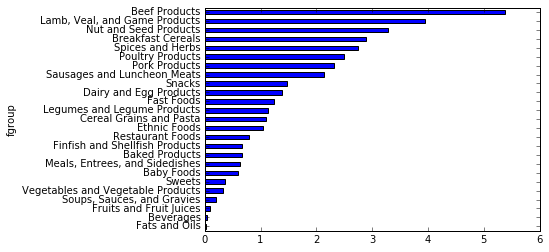

In [80]:
# 음식 그룹과 영양소의 종류별 중간값을 그래프로 그려낼 수 있다.
%matplotlib inline
import matplotlib

result = ndata.groupby(['nutrient', 'fgroup'])['value'].quantile(0.5)
result['Zinc, Zn'].sort_values().plot(kind='barh')

In [85]:
# 조금 더 응용하면 각 영양소가 어떤 음식에 가장 많이 들어있는지 찾아볼 수도 있다.
by_nutrient = ndata.groupby(['nutgroup', 'nutrient'])

get_maximum = lambda x: x.xs(x.value.idxmax())
get_minimum = lambda x: x.xs(x.value.idxmin())
    
max_foods = by_nutrient.apply(get_maximum)[['value', 'food']]

max_foods.food = max_foods.food.str[:50]
max_foods

value  \
nutgroup    nutrient                                     
Amino Acids Alanine                              8.009   
            Arginine                             7.436   
            Aspartic acid                       10.203   
            Cystine                              1.307   
            Glutamic acid                       17.452   
            Glycine                             19.049   
            Histidine                            2.999   
            Hydroxyproline                       0.803   
            Isoleucine                           4.300   
            Leucine                              7.200   
            Lysine                               6.690   
            Methionine                           1.859   
            Phenylalanine                        4.600   
            Proline                             12.295   
            Serine                               4.600   
            Threonine                            3.300   
            Tryptophan                           1.600   
            Tyrosine                             3.300   
            Valine                               4.500   
Composition Adjusted Protein                    12.900   
            Carbohydrate, by difference        100.000   
            Fiber, total dietary                79.000   
            Protein                             88.320   
            Sugars, total                       99.800   
            Total lipid (fat)                  100.000   
            Water                              100.000   
Elements    Calcium, Ca                       7364.000   
            Copper, Cu                          15.050   
            Fluoride, F                        584.000   
            Iron, Fe                            87.470   
...                                                ...   
Vitamins    Cryptoxanthin, beta               6186.000   
            Dihydrophylloquinone               103.800   
            Folate, DFE                       2630.000   
            Folate, food                      2340.000   
            Folate, total                     2340.000   
            Folic acid                        1538.000   
            Lutein + zeaxanthin              39550.000   
            Lycopene                         46260.000   
            Menaquinone-4                       33.200   
            Niacin                              97.000   
            Pantothenic acid                    35.000   
            Retinol                          30000.000   
            Riboflavin                          14.300   
            Thiamin                             20.000   
            Tocopherol, beta                     6.490   
            Tocopherol, delta                   30.880   
            Tocopherol, gamma                  100.880   
            Vitamin A, IU                   100000.000   
            Vitamin A, RAE                   30000.000   
            Vitamin B-12                        98.890   
            Vitamin B-12, added                 24.000   
            Vitamin B-6                         12.000   
            Vitamin C, total ascorbic acid    2400.000   
            Vitamin D                        10000.000   
            Vitamin D (D2 + D3)                250.000   
            Vitamin D2 (ergocalciferol)         28.100   
            Vitamin D3 (cholecalciferol)        27.400   
            Vitamin E (alpha-tocopherol)       149.400   
            Vitamin E, added                    46.550   
            Vitamin K (phylloquinone)         1714.500   

                                                                                         food  
nutgroup    nutrient                                                                           
Amino Acids Alanine                                         Gelatins, dry powder, unsweetened  
            Arginine                                             Seeds, sesame flour, low-fat  
          